In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array, array_to_img
import glob
import matplotlib.image as mpimg
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
dir_h = '/imgs'
dir_mask = '/masks'
train = '/train'
train_mask = '/train_masks' 
path='gdrive/My Drive/SS'

In [4]:
img = sorted(os.listdir(path+dir_h+train))
mask = sorted(os.listdir(path+dir_mask+train_mask))

In [5]:
img, val_imgs, mask, val_masks = train_test_split(img, mask, test_size=0.2, random_state=6)

In [6]:
val_imgs, test_imgs, val_masks, test_masks = train_test_split(val_imgs, val_masks, test_size=0.5, random_state=6)

In [7]:
input_size = [128, 128, 3]
def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    data_size = len(image_ids)
    while True:
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        masks = []
        for i in rnd_ind:
            img_id, mask_id = image_ids[i], mask_ids[i]
            img = load_img(images_path + img_id, target_size=img_size) 
            mask = load_img(masks_path + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.

In [8]:
train1 = data_generator(path+dir_h+train+'/', path+dir_mask+train_mask+'/', img, mask, batch_size=32)

In [9]:
val = data_generator(path+dir_h+train+'/', path+dir_mask+train_mask+'/', val_imgs, val_masks, batch_size=32)

In [10]:
test = data_generator(path+dir_h+train+'/', path+dir_mask+train_mask+'/', test_imgs, test_masks, batch_size=32)

In [11]:
def Unet(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)


    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
 
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = Unet()

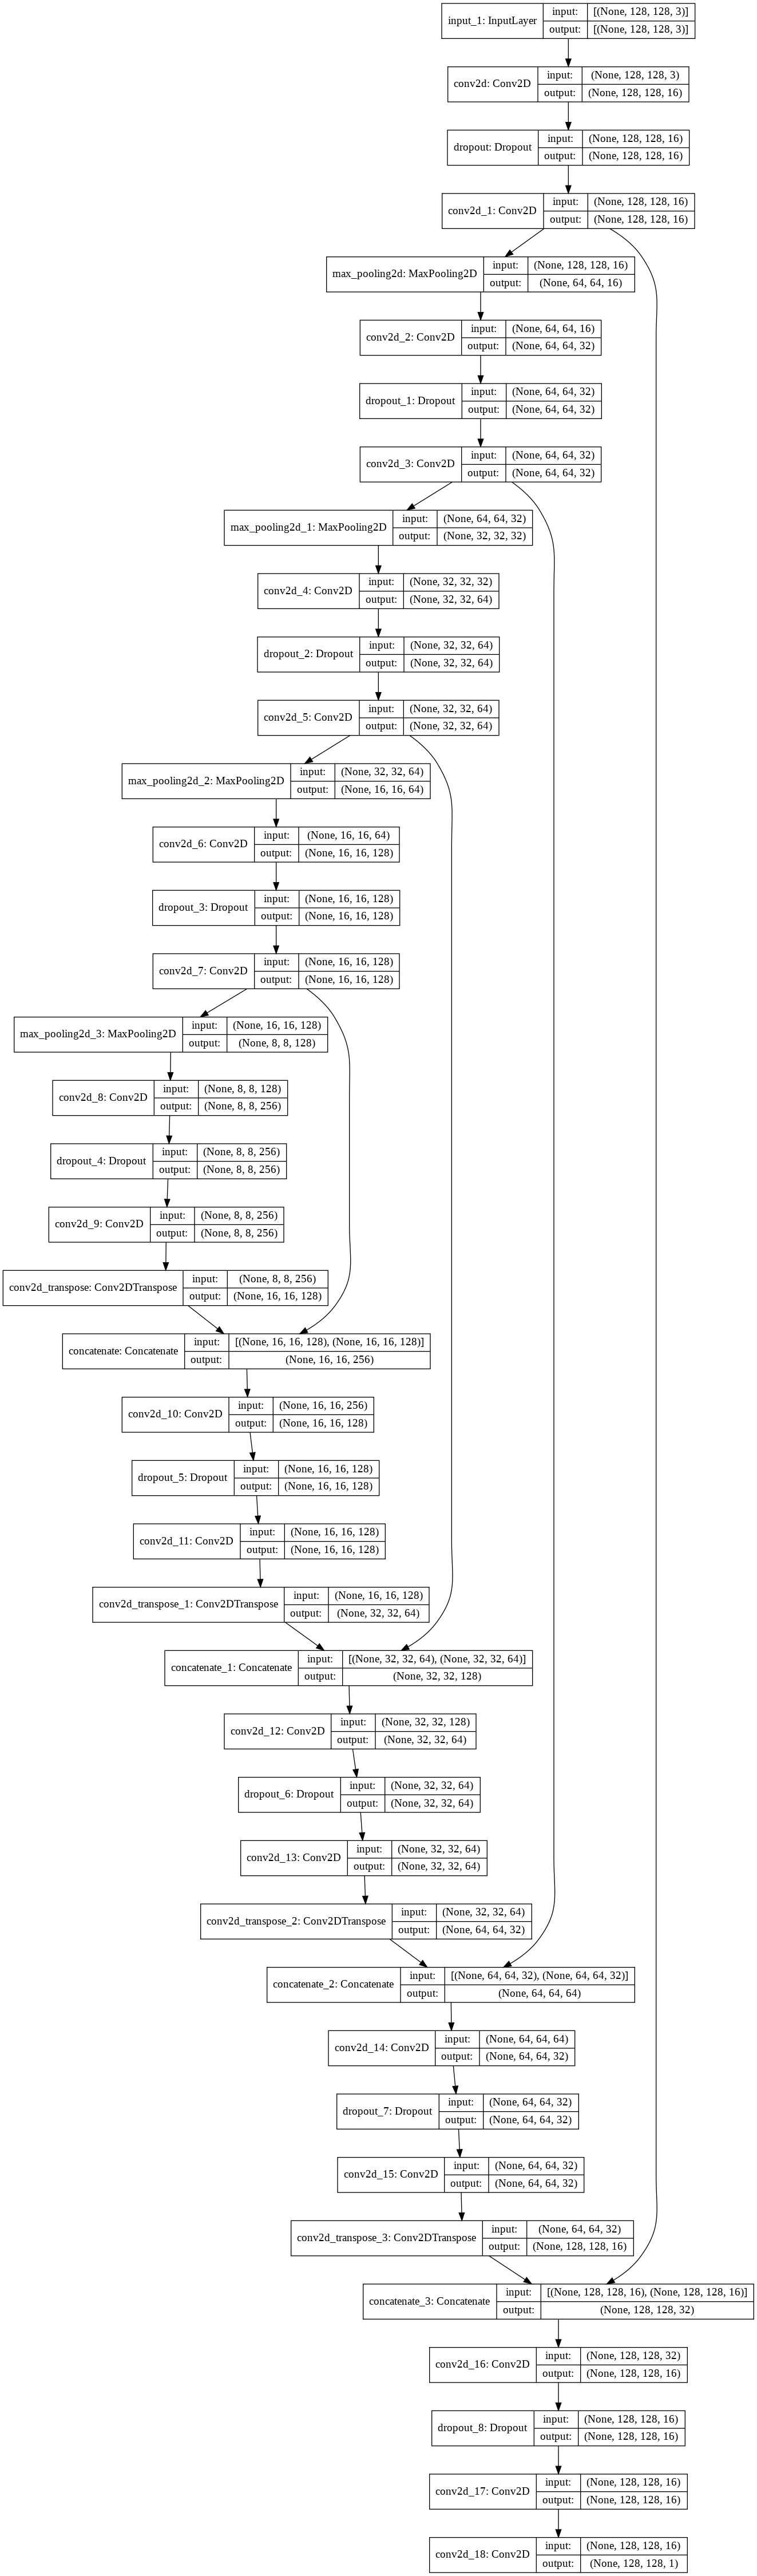

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:

model_history = model.fit(train1, epochs=8,
                          steps_per_epoch=100,
                          validation_steps=100,
                          validation_data=val)

Epoch 1/8
100/100 [==============================] - 256s 3s/step - loss: 0.2805 - accuracy: 0.8708 - val_loss: 0.0910 - val_accuracy: 0.9648
Epoch 2/8
100/100 [==============================] - 254s 3s/step - loss: 0.0493 - accuracy: 0.9799 - val_loss: 0.0549 - val_accuracy: 0.9782
Epoch 3/8
100/100 [==============================] - 255s 3s/step - loss: 0.0341 - accuracy: 0.9860 - val_loss: 0.0470 - val_accuracy: 0.9812
Epoch 4/8
100/100 [==============================] - 253s 3s/step - loss: 0.0288 - accuracy: 0.9883 - val_loss: 0.0268 - val_accuracy: 0.9892
Epoch 5/8
100/100 [==============================] - 253s 3s/step - loss: 0.0244 - accuracy: 0.9900 - val_loss: 0.0299 - val_accuracy: 0.9888
Epoch 6/8
100/100 [==============================] - 251s 3s/step - loss: 0.0219 - accuracy: 0.9911 - val_loss: 0.0250 - val_accuracy: 0.9902
Epoch 7/8
100/100 [==============================] - 254s 3s/step - loss: 0.0203 - accuracy: 0.9918 - val_loss: 0.0193 - val_accuracy: 0.9924
Epoch 

Text(0, 0.5, 'loss')

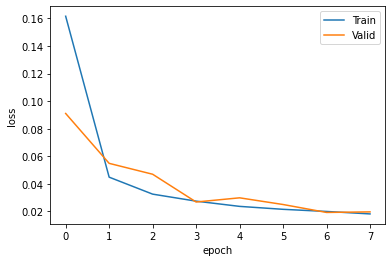

In [15]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Train', 'Valid'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [16]:
imgs1, masks1 = next(test)

In [17]:
pred_masks = model.predict(imgs1)

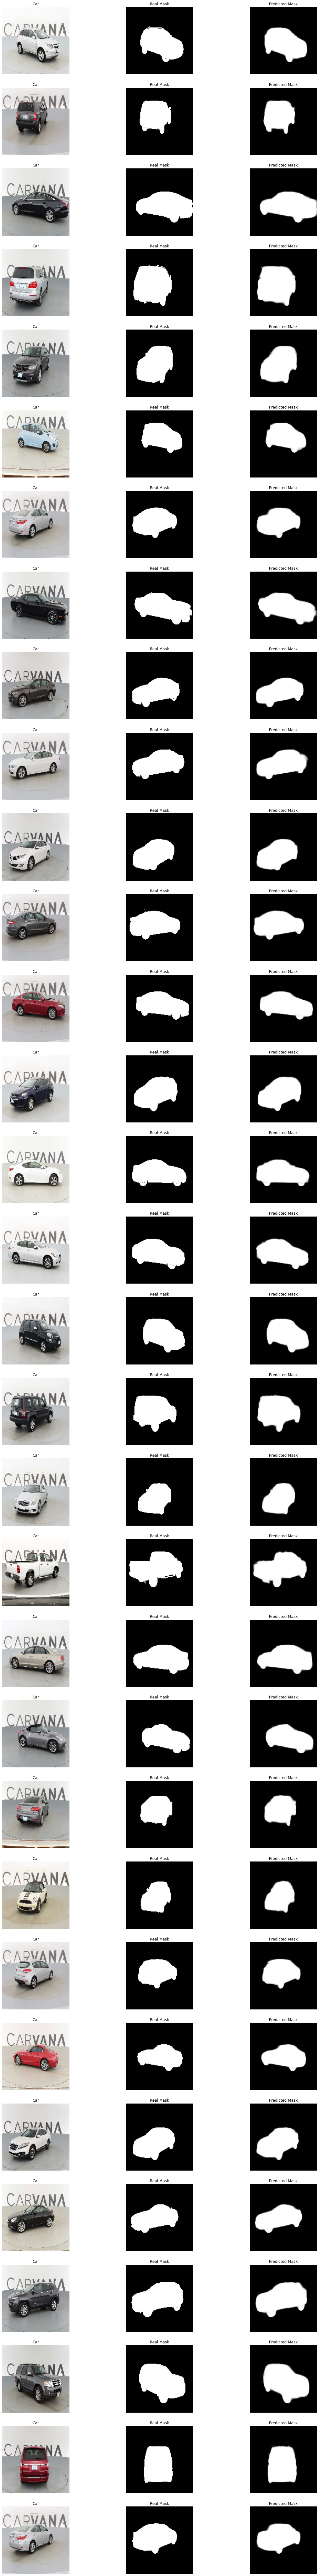

In [18]:
fig, ax = plt.subplots(32, 3, figsize=(20,150))
for i in range(32):
    ax[i, 0].imshow(imgs1[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Car')
    
    ax[i, 1].imshow(masks1[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 